
##**ECE 763 Project 3**
#**Sahil Deshpande (200375597)**
#**Shivani Shendre (200375416)**

#Babysitting the DNN

Importing Libraries

In [1]:
import cv2
import os
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, Reshape,BatchNormalization, GlobalAveragePooling2D
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow
from tensorflow.keras import initializers

Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
dataPath = '/content/gdrive/My Drive/Semester_3/ECE_763/Projects/Project_3/Face Data/'

Mounted at /content/gdrive


Loading Data (Image size - 60x60 with Linear Interpolation)

In [3]:
def load_data(path):
    dirs = os.listdir(path)
    dataset = []
    for item in dirs:
        if os.path.isfile(path+item):
            inputImage = cv2.imread(path + item)
            inputImage = cv2.resize(inputImage,(60,60),interpolation = cv2.INTER_LINEAR)
            dataset.append(inputImage)
    return dataset

Splitting the Training, Testing and Validation Data

In [4]:
faceData = load_data(dataPath + "face_training/")
nonFaceData = load_data(dataPath + "nonface_training/")
tFaceData = load_data(dataPath + "face_testing/")
tNonFaceData = load_data(dataPath + "nonface_testing/")

dataset = np.concatenate((np.array(faceData),np.array(nonFaceData)))
labels = np.concatenate((1*np.ones(len(faceData),dtype = "uint8"), 0*np.ones(len(faceData),dtype = "uint8")))

X_test = np.concatenate((np.array(tFaceData),np.array(tNonFaceData)))
y_test = np.concatenate((1*np.ones(len(tFaceData),dtype = "uint8"), 0*np.ones(len(tNonFaceData),dtype = "uint8")))


X_train, X_val, y_train, y_val = train_test_split(dataset, labels,test_size=0.2)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1600, 60, 60, 3), (1600,), (400, 60, 60, 3), (400,))

Creating Model 1
(Model without BatchNorm)

In [5]:
def model1(input_size, lr, reg):

  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu',input_shape = input_size, kernel_regularizer = regularizers.l2(reg) ))
  model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='valid'))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(reg)))
  model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='valid'))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=86, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(reg)))
  model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='valid'))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(units = 84, activation='relu',kernel_regularizer=regularizers.l2(reg)))

  model.add(Dense(units= 2, activation='softmax'))
  model.compile(optimizer= optimizers.SGD(lr = lr),loss='sparse_categorical_crossentropy',metrics=['acc'])
#  print(model.summary())
  return model

Checking Loss and Accuracy before Normalizing the data

In [6]:
model = model1(X_train.shape[1:],0.001,0)
initial_loss, grad = model.evaluate(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


50/50 [==============================] - 9s 4ms/step - loss: 15.6600 - acc: 0.5144


Normalizing the data

In [7]:
mean_train, std_train = np.mean(np.array(X_train), axis=0), np.std(np.array(X_train), axis=0)
X_train = (X_train - mean_train)/(std_train+1e-6) 
mean_test, std_test = np.mean(np.array(X_test), axis=0), np.std(np.array(X_test), axis=0)
X_test = (X_test - mean_test)/(std_test+1e-6)
mean_val, std_val = np.mean(np.array(X_val), axis=0), np.std(np.array(X_val), axis=0)
X_val = (X_val - mean_val)/(std_val+1e-6)

Checking Loss and Accuracy after normalizing data - without regularization

In [8]:
model = model1(X_train.shape[1:],0.001,0)
initial_loss, grad = model.evaluate(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


50/50 [==============================] - 0s 4ms/step - loss: 0.6468 - acc: 0.7619


Checking Loss and Accuracy after normalizing data - with regularization

In [9]:
model = model1(X_train.shape[1:],0.001,0.01)
initial_loss, grad = model.evaluate(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


50/50 [==============================] - 1s 4ms/step - loss: 3.5584 - acc: 0.5219


Model with Low Learning Rate and Low Regularization

In [10]:
model = model1(X_train.shape[1:],1e-6,1e-6)
history = model.fit(X_train,y_train,batch_size=20,epochs=10, verbose=1,validation_data=(X_val,y_val))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


80/80 [==============================] - 2s 8ms/step - loss: 0.7983 - acc: 0.5069 - val_loss: 0.7222 - val_acc: 0.4550
Epoch 2/10
80/80 [==============================] - 0s 5ms/step - loss: 0.7970 - acc: 0.5063 - val_loss: 0.7220 - val_acc: 0.4550
Epoch 3/10
80/80 [==============================] - 0s 5ms/step - loss: 0.8023 - acc: 0.5063 - val_loss: 0.7217 - val_acc: 0.4550
Epoch 4/10
80/80 [==============================] - 0s 5ms/step - loss: 0.7932 - acc: 0.5056 - val_loss: 0.7215 - val_acc: 0.4550
Epoch 5/10
80/80 [==============================] - 0s 5ms/step - loss: 0.7954 - acc: 0.5038 - val_loss: 0.7212 - val_acc: 0.4550
Epoch 6/10
80/80 [==============================] - 0s 5ms/step - loss: 0.7978 - acc: 0.5031 - val_loss: 0.7210 - val_acc: 0.4550
Epoch 7/10
80/80 [==============================] - 0s 5ms/step - loss: 0.7904 - acc: 0.5100 - val_loss: 0.7208 - val_acc: 0.4550
Epoch 8/10
80/80 [==============================] - 0s 5ms/step - loss: 0.7946 - acc: 0.5044 - val_lo

Model with High Learning Rate and Low Regularization

In [21]:
model = model1(X_train.shape[1:],1e6,1e-6)
history = model.fit(X_train,y_train,batch_size=20,epochs=10, verbose=1,validation_data=(X_val,y_val))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


80/80 [==============================] - 1s 9ms/step - loss: nan - acc: 0.4900 - val_loss: nan - val_acc: 0.5450
Epoch 2/10
80/80 [==============================] - 0s 5ms/step - loss: nan - acc: 0.4888 - val_loss: nan - val_acc: 0.5450
Epoch 3/10
80/80 [==============================] - 0s 5ms/step - loss: nan - acc: 0.4888 - val_loss: nan - val_acc: 0.5450
Epoch 4/10
80/80 [==============================] - 0s 5ms/step - loss: nan - acc: 0.4888 - val_loss: nan - val_acc: 0.5450
Epoch 5/10
80/80 [==============================] - 0s 5ms/step - loss: nan - acc: 0.4888 - val_loss: nan - val_acc: 0.5450
Epoch 6/10
80/80 [==============================] - 0s 6ms/step - loss: nan - acc: 0.4888 - val_loss: nan - val_acc: 0.5450
Epoch 7/10
80/80 [==============================] - 0s 5ms/step - loss: nan - acc: 0.4888 - val_loss: nan - val_acc: 0.5450
Epoch 8/10
80/80 [==============================] - 0s 5ms/step - loss: nan - acc: 0.4888 - val_loss: nan - val_acc: 0.5450
Epoch 9/10
80/80 [=

Overfiting Training Data

In [22]:
model = model1(X_train.shape[1:],3e-3,0)
X_tiny, y_tiny = X_train[0:20], y_train[0:20]
hist_overfit = model.fit(X_train,y_train,epochs=200, verbose=1,validation_data=(X_tiny,y_tiny))

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


50/50 [==============================] - 2s 11ms/step - loss: 0.6370 - acc: 0.6794 - val_loss: 0.5805 - val_acc: 0.9500
Epoch 2/200
50/50 [==============================] - 0s 6ms/step - loss: 0.4682 - acc: 0.8462 - val_loss: 0.4407 - val_acc: 0.9500
Epoch 3/200
50/50 [==============================] - 0s 6ms/step - loss: 0.3487 - acc: 0.8963 - val_loss: 0.3499 - val_acc: 1.0000
Epoch 4/200
50/50 [==============================] - 0s 7ms/step - loss: 0.2987 - acc: 0.9006 - val_loss: 0.2842 - val_acc: 1.0000
Epoch 5/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2502 - acc: 0.9187 - val_loss: 0.2501 - val_acc: 1.0000
Epoch 6/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2127 - acc: 0.9287 - val_loss: 0.2139 - val_acc: 1.0000
Epoch 7/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1973 - acc: 0.9312 - val_loss: 0.1978 - val_acc: 1.0000
Epoch 8/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1794 - acc: 0.9394 

Coarse Search of Regularization and Learning Rate

In [23]:
maxCount = 100
input_size = X_test.shape[1:]
coarse_parameters = []
for count in range(maxCount):
  reg = 10 ** np.random.uniform(-5,5)
  lr = 10 ** np.random.uniform(-3,-6)
  model = model1(input_size,lr,reg)
  history = model.fit(X_train,y_train,batch_size=32,epochs=5, verbose=False,validation_data=(X_val,y_val))

  storeParameters = [history.history['val_acc'][4],lr,reg, count]
  coarse_parameters.append(storeParameters)
  print("val_acc:",history.history['val_acc'][4],", lr:",lr,", reg:",reg,",(",count," / 100)")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


val_acc: 0.8450000286102295 , lr: 0.000813066048109511 , reg: 3.663166614825683e-05 ,( 0  / 100)
val_acc: 0.7674999833106995 , lr: 0.00016130058515705762 , reg: 0.0012123565269507187 ,( 1  / 100)
val_acc: 0.5375000238418579 , lr: 1.571392389069239e-06 , reg: 0.011918732306193667 ,( 2  / 100)
val_acc: 0.45500001311302185 , lr: 3.208401414127829e-05 , reg: 97.6379167041552 ,( 3  / 100)
val_acc: 0.45500001311302185 , lr: 2.627620030378623e-05 , reg: 848.6217312382864 ,( 4  / 100)
val_acc: 0.4375 , lr: 1.2118173575764867e-05 , reg: 0.007398583410173065 ,( 5  / 100)
val_acc: 0.6025000214576721 , lr: 6.70575259237439e-05 , reg: 0.007917207240987057 ,( 6  / 100)
val_acc: 0.5450000166893005 , lr: 1.8208982832765503e-05 , reg: 81561.71414224479 ,( 7  / 100)
val_acc: 0.637499988079071 , lr: 1.577629494123181e-05 , reg: 2.0066942829276995 ,( 8  / 100)
val_acc: 0.8050000071525574 , lr: 0.00019378930537337596 , reg: 0.00040918260285036366 ,( 9  / 100)
val_acc: 0.45500001311302185 , lr: 8.6058506839

Top 10 parameters with best validation accuracy




In [24]:
coarse_parameters = np.array(coarse_parameters)
best_coarse = coarse_parameters[coarse_parameters[:,0].argsort()]
best_coarse[90:100,:]

array([[8.12500000e-01, 4.35944384e-04, 2.85211523e-04, 3.60000000e+01],
       [8.17499995e-01, 5.18892406e-04, 1.02245446e-05, 6.30000000e+01],
       [8.19999993e-01, 4.10192338e-04, 7.17655942e-04, 1.40000000e+01],
       [8.29999983e-01, 9.82801142e-04, 4.78842465e-01, 1.20000000e+01],
       [8.32499981e-01, 4.34129115e-04, 3.40424840e-01, 2.50000000e+01],
       [8.34999979e-01, 9.38471481e-04, 1.07440379e-01, 6.60000000e+01],
       [8.45000029e-01, 8.13066048e-04, 3.66316661e-05, 0.00000000e+00],
       [8.52500021e-01, 3.80907236e-04, 6.69349990e-04, 5.70000000e+01],
       [8.52500021e-01, 8.06314777e-04, 4.88905564e-03, 7.90000000e+01],
       [8.57500017e-01, 5.83857490e-04, 3.73120385e-03, 1.90000000e+01]])

Fine Search of Regularization and Learning Rate

In [25]:
#Fine Search
maxCount = 100
input_size = X_test.shape[1:]
fine_parameters = []
for count in range(maxCount):
  reg = 10 ** np.random.uniform(-2,-5)
  lr = 10 ** np.random.uniform(-5,-3)
  model = model1(input_size,lr,reg)
  history = model.fit(X_train,y_train,batch_size=20,epochs=20, verbose=False,validation_data=(X_test,y_test))
  storeParameters = [history.history['val_acc'][4],lr,reg, count]
  fine_parameters.append(storeParameters)
  print("val_acc:",history.history['val_acc'][4],", lr:",lr,", reg:",reg,",(",count," / 100)")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


val_acc: 0.675000011920929 , lr: 2.478489776273387e-05 , reg: 0.0002855308129166824 ,( 0  / 100)
val_acc: 0.6050000190734863 , lr: 2.3000176436630866e-05 , reg: 0.001274777024290008 ,( 1  / 100)
val_acc: 0.8149999976158142 , lr: 0.00043423735673555014 , reg: 0.001167529240930489 ,( 2  / 100)
val_acc: 0.8299999833106995 , lr: 0.0005690880784728123 , reg: 6.02935626743309e-05 ,( 3  / 100)
val_acc: 0.6700000166893005 , lr: 5.068465226079132e-05 , reg: 0.0020641349462540742 ,( 4  / 100)
val_acc: 0.4449999928474426 , lr: 4.2432232359904304e-05 , reg: 0.0009900098289802105 ,( 5  / 100)
val_acc: 0.8149999976158142 , lr: 0.00016069661648057839 , reg: 0.0002763489052418847 ,( 6  / 100)
val_acc: 0.41499999165534973 , lr: 1.1154076813109774e-05 , reg: 8.853685047598415e-05 ,( 7  / 100)
val_acc: 0.4350000023841858 , lr: 1.3808349490441541e-05 , reg: 0.005709891127180691 ,( 8  / 100)
val_acc: 0.6399999856948853 , lr: 2.854573644822658e-05 , reg: 0.0014135094659843282 ,( 9  / 100)
val_acc: 0.8550000

Top 10 parameters with best validation accuracy




In [26]:
fine_parameters = np.array(fine_parameters)
best_fine = fine_parameters[fine_parameters[:,0].argsort()]
best_fine[90:100,:]

array([[8.70000005e-01, 7.19942596e-04, 3.53242653e-03, 4.70000000e+01],
       [8.70000005e-01, 4.65048996e-04, 1.12378818e-05, 9.60000000e+01],
       [8.75000000e-01, 5.69906394e-04, 3.87082972e-04, 3.50000000e+01],
       [8.75000000e-01, 8.16893266e-04, 2.36117431e-03, 8.10000000e+01],
       [8.79999995e-01, 7.57318757e-04, 9.47895247e-04, 9.20000000e+01],
       [8.84999990e-01, 5.87979422e-04, 2.00758238e-03, 1.50000000e+01],
       [8.84999990e-01, 9.06141970e-04, 1.75409793e-05, 3.60000000e+01],
       [8.89999986e-01, 4.86012092e-04, 7.54829106e-04, 2.50000000e+01],
       [8.89999986e-01, 3.44696623e-04, 1.45049166e-05, 4.90000000e+01],
       [9.10000026e-01, 3.71538027e-04, 3.96459921e-05, 2.30000000e+01]])

Training the model with the best parameters found after fine search

In [27]:
model = model1(X_train.shape[1:], 3.71538027e-04, 3.96459921e-05)
history = model.fit(X_train,y_train,batch_size=20,epochs=50, verbose=True,validation_data=(X_val,y_val))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


80/80 [==============================] - 3s 17ms/step - loss: 0.6790 - acc: 0.5775 - val_loss: 0.6758 - val_acc: 0.7625
Epoch 2/50
80/80 [==============================] - 0s 6ms/step - loss: 0.6341 - acc: 0.7038 - val_loss: 0.6584 - val_acc: 0.8025
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 0.6077 - acc: 0.7400 - val_loss: 0.6391 - val_acc: 0.7925
Epoch 4/50
80/80 [==============================] - 0s 5ms/step - loss: 0.5744 - acc: 0.7881 - val_loss: 0.6163 - val_acc: 0.8000
Epoch 5/50
80/80 [==============================] - 0s 5ms/step - loss: 0.5454 - acc: 0.8037 - val_loss: 0.5924 - val_acc: 0.8225
Epoch 6/50
80/80 [==============================] - 0s 5ms/step - loss: 0.5155 - acc: 0.8263 - val_loss: 0.5675 - val_acc: 0.8350
Epoch 7/50
80/80 [==============================] - 0s 5ms/step - loss: 0.4848 - acc: 0.8456 - val_loss: 0.5437 - val_acc: 0.8550
Epoch 8/50
80/80 [==============================] - 0s 5ms/step - loss: 0.4536 - acc: 0.8606 - val_l

Plotting Accuracy and Loss curves for Training and Validation data

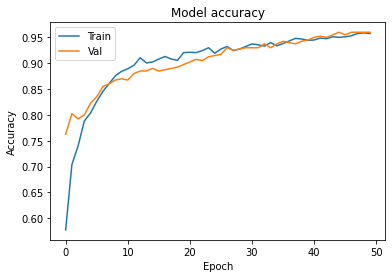

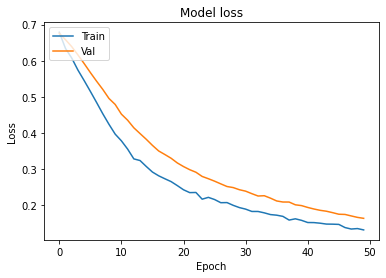

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Confusion matrix to demonstrate performance on test data





Accuracy on Test Data:  0.975 



(<Figure size 144x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa53c1eacd0>)

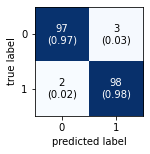

In [29]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print("Accuracy on Test Data: ",accuracy_score(y_test, y_pred),"\n")
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(2,2), show_normed=True)

Xavier Weight Initialization + BatchNorm

In [31]:
def model2(input_size, lr, reg):
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu',input_shape = input_size, kernel_regularizer = regularizers.l2(reg), kernel_initializer= initializers.GlorotUniform(seed = None)))
  model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='valid'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(reg), kernel_initializer= initializers.GlorotUniform(seed = None)))
  model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='valid'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=86, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(reg), kernel_initializer= initializers.GlorotUniform(seed = None)))
  model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='valid'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units = 84, activation='relu',kernel_regularizer=regularizers.l2(reg), kernel_initializer= initializers.GlorotUniform(seed = None)))
  model.add(BatchNormalization())
  model.add(Dense(units= 2, activation='softmax'))

  model.compile(optimizer= optimizers.SGD(lr = lr),loss='sparse_categorical_crossentropy',metrics=['acc'],)
  #print(model.summary())
  return model

model = model2(X_train.shape[1:], 3.71538027e-04, 3.96459921e-05)
history = model.fit(X_train,y_train,batch_size=20,epochs=50, verbose=True,validation_data=(X_val,y_val))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


80/80 [==============================] - 2s 10ms/step - loss: 0.5123 - acc: 0.7806 - val_loss: 0.6640 - val_acc: 0.5625
Epoch 2/50
80/80 [==============================] - 0s 6ms/step - loss: 0.2867 - acc: 0.8856 - val_loss: 0.5609 - val_acc: 0.8325
Epoch 3/50
80/80 [==============================] - 0s 6ms/step - loss: 0.2088 - acc: 0.9306 - val_loss: 0.4405 - val_acc: 0.8775
Epoch 4/50
80/80 [==============================] - 0s 6ms/step - loss: 0.1958 - acc: 0.9275 - val_loss: 0.3444 - val_acc: 0.8800
Epoch 5/50
80/80 [==============================] - 0s 6ms/step - loss: 0.1545 - acc: 0.9431 - val_loss: 0.2427 - val_acc: 0.9350
Epoch 6/50
80/80 [==============================] - 0s 6ms/step - loss: 0.1436 - acc: 0.9456 - val_loss: 0.1886 - val_acc: 0.9525
Epoch 7/50
80/80 [==============================] - 1s 7ms/step - loss: 0.1173 - acc: 0.9619 - val_loss: 0.1418 - val_acc: 0.9650
Epoch 8/50
80/80 [==============================] - 1s 6ms/step - loss: 0.1151 - acc: 0.9656 - val_l

Plotting Accuracy and Loss curves for Training and Validation data

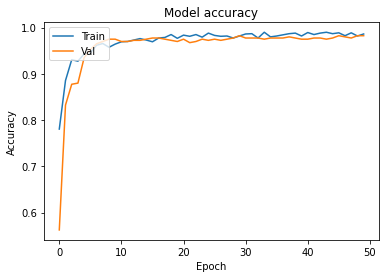

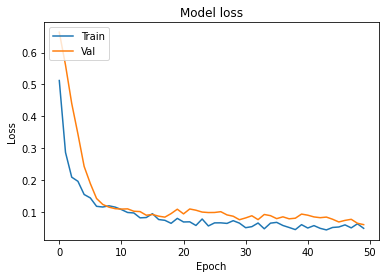

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Confusion matrix to demonstrate performance on test data

Accuracy on Test Data:  0.975 



(<Figure size 144x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa5ba58d4d0>)

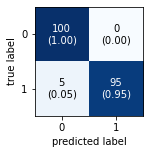

In [33]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print("Accuracy on Test Data: ",accuracy_score(y_test, y_pred),"\n")
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(2,2), show_normed=True)